# Numerically Controlled Oscillator (NCO)
This notebook is used to develop the NCO which will later be developed in hardware

### Install Dependencies:

In [2]:
pip install matplotlib numpy


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


### Parameters

In [49]:
import numpy as np
import matplotlib.pyplot as plt

FS = 48000 # sample rate
N_PA = 32 # phase accumulator bit width
N_LUT = 10 # lookup table bit width (1024 entries)
N_SR = 24 # sample rate bit width
F_CLK = 100000000 # 100MHz clock frequency
MIDI_RANGE = 128 # MIDI takes value x, {0≤x≤127}
A4 = 69 # note A4 is the 69th note (440Hz)

### Calculate Word Values
The mathematical equation that relates the output frequency (Fout​) of a DDS synthesizer to the tuning word (M) is given by:

$F_{out}=\frac{M⋅F_{clk}}{2^n}$

##### frequency derivation
$f(n) = 440\cdot2^{\frac{n-69}{12}}$
A4 (440Hz) is the 69th note

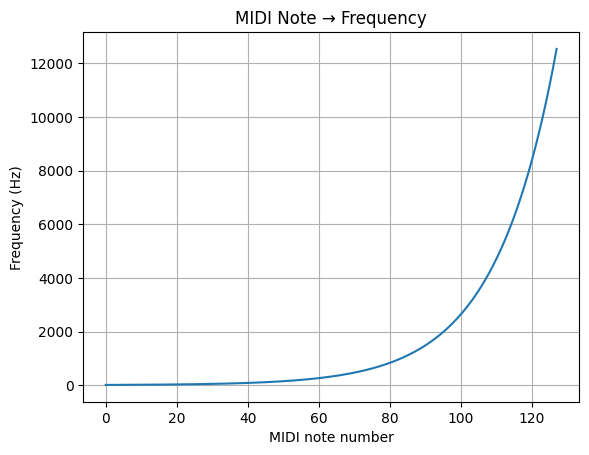

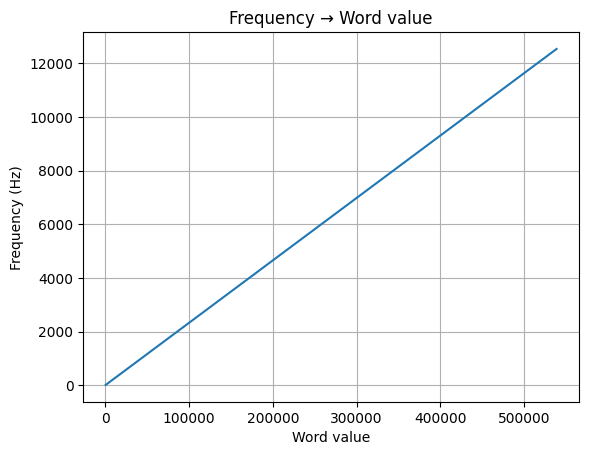

In [51]:
note_freqs = [0.0] * MIDI_RANGE
for i in range(MIDI_RANGE):
    exponent = (i - 69) / 12
    note_freqs[i] = 440*np.power(2,exponent)

pa_words = [0] * MIDI_RANGE 
for i in range(MIDI_RANGE):
    pa_words[i] = (note_freqs[i]*2**N_PA)/F_CLK

# plot midi note to frequency
notes = np.arange(len(note_freqs))
plt.figure()
plt.plot(notes, note_freqs)
plt.xlabel("MIDI note number")
plt.ylabel("Frequency (Hz)")
plt.title("MIDI Note → Frequency")
plt.grid(True)
plt.show()

# plot frequency to word value
plt.figure()
plt.plot(pa_words, note_freqs)
plt.xlabel("Word value")
plt.ylabel("Frequency (Hz)")
plt.title("Frequency → Word value")
plt.grid(True)
plt.show()

### Look-Up Table (LUT) Construction
The following table uses a sine wave. The values stored in the table are given by:
$y_k = sin(2\pi k/N)$ where k is an intger between 0 and N where N is $2^{N\_LUT}$

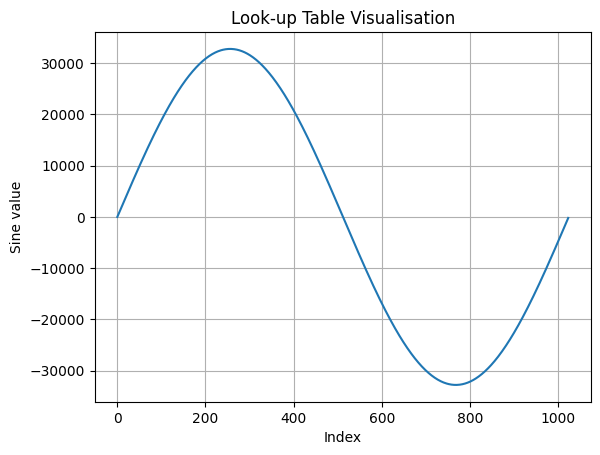

In [ ]:
N_LUT = 10
LUT_LEN = 1 << N_LUT
AMP_BITS = 15  

sin_lut = np.round(
    np.sin(2 * np.pi * np.arange(LUT_LEN) / LUT_LEN)
    * (1 << AMP_BITS)
).astype(np.int32)
# LUT values need to be scaled so that they can be stored as integers to avoid floating point arithmetic

plt.figure()
plt.plot(k, sin_lut)
plt.xlabel("Index")
plt.ylabel("Sine value")
plt.title("Look-up Table Visualisation")
plt.grid(True)
plt.show()

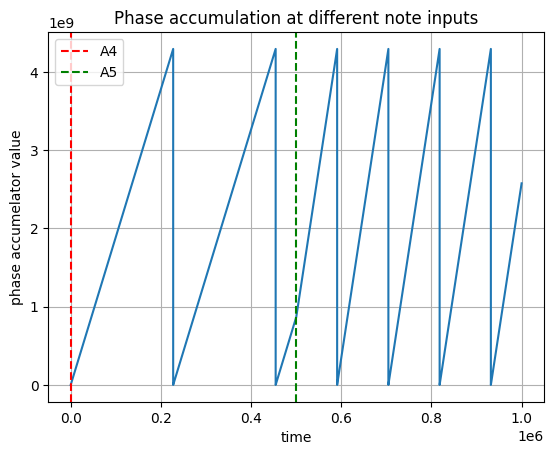

In [63]:
### Phase accumulator
def phase_accumulator(previous_value, midi_note):
    return (previous_value + pa_words[midi_note])%(1<<N_PA)

NUM_SAMPLES = 1000000
time = np.arange(NUM_SAMPLES) 
simulated_values = [0] * NUM_SAMPLES



for i in range(NUM_SAMPLES//2):
    if i > 0 :
        simulated_values[i] = phase_accumulator(simulated_values[i-1], A4)
    else:
        simulated_values[i] = phase_accumulator(0,A4)


for i in range(NUM_SAMPLES//2):
    simulated_values[i+NUM_SAMPLES//2] = phase_accumulator(simulated_values[(i+NUM_SAMPLES//2)-1], A4+12)

# plot phase accumulator
plt.figure()
plt.plot(time, simulated_values)
plt.xlabel("time")
plt.ylabel("phase accumelator value")
plt.axvline(x=0, color='r', linestyle='--', label='A4')
plt.axvline(x=NUM_SAMPLES//2, color='g', linestyle='--', label='A5')
plt.title("Phase accumulation at different note inputs")
plt.grid(True)
plt.legend()
plt.show()


### Matching Phase Accumulator value to LUT entry
In the event that the phase accumulator word size is larger than the bit width of the lookup table, we will have to bit shift the PA word $(N\_PA-N\_LUT)$ bits right in order to index into the table correctly. This operation always rounds down the PA value.

In order to increase the pitch output accuracy, linear interpolation can be used. As we always round down, we can use the last $(N\_PA-N\_LUT)$ bits of the PA word to determine how far we are between the LUT index, $i$, as selected by the first $N\_LUT$ bits and LUT index $i+1$

In [ ]:
#phase_accumulator>>(N_PA-N_LUT) #Left with N_LUT bits. We always truncate (round down) - check the next lut value for linear interpolation

#output_waveform = sin_lut

def lin_interp(lower_index, frac_index, N_FRAC, lut):
    lower = lut[lower_index]
    upper = lut[(lower_index+1)%len(lut)] # wrap if out of bounds

    diff = upper - lower

    #print(f"{lower}, {upper}, {diff}")
    return lower + ((diff * frac_index) >> N_FRAC)




18868, 19032, 164
18893
